In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# unique functions for this notebook
import numpy.ma as ma
from scipy.stats import hmean
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
import flopy
# try:
#     import flopy
#     from flopy.discretization.structuredgrid import StructuredGrid
#     from flopy.utils.reference import SpatialReference
#     from flopy.utils import Raster
# except:
#     import flopy
#     fpth = os.path.abspath(os.path.join('..', '..'))
#     sys.path.append(fpth)
#     from flopy.discretization.structuredgrid import StructuredGrid
#     from flopy.utils.reference import SpatialReference
#     from flopy.utils import Raster
# from flopy.utils.gridgen import Gridgen
# from flopy.utils import OptionBlock
# import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.4
flopy version: 3.3.3


In [3]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
# upw dir
upw_dir = gwfm_dir+'/UPW_data'

In [25]:
# use the simpler model with less load required
# use the simpler model with less load required
# loadpth = gwfm_dir+'/JupyterNotebooks/WEL/data'

load_only = ['BAS6','DIS']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt',
                               load_only = load_only
                              )


In [26]:
nrow = m.dis.nrow
ncol = m.dis.ncol
nlay = m.dis.nlay

In [27]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')

### Load kriged water table data

In [28]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [29]:
strtyear = 2013
endyear = 2019
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

kriged_NW = np.zeros((int(endyear-strtyear)*2,ncol))
kriged_SE = np.zeros((int(endyear-strtyear)*2,ncol))
# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

t=0
for year in np.arange(strtyear,endyear):
    
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_spring[t,:,:] = df_grid
    
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_fall[t,:,:] = df_grid

    
    # save NW  dataframe
    kriged_NW[t] = kriged_spring[t,0,:]
    kriged_NW[2*t] = kriged_fall[t,0,:]
    # save SE data frame
    kriged_SE[t] = kriged_spring[t,0,:]
    kriged_SE[2*t] = kriged_fall[t,0,:]
    
    year_to_int[t,0] = t
    year_to_int[t,1] = year
    t+=1
    

In [30]:
print(np.arange(strtyear, endyear),'mean water elevation by year',np.nanmean(df_grid,axis=(0,1)))
# 2015 represents the lowest water, 2018 the highest, 2016 median

[2013 2014 2015 2016 2017 2018] mean water elevation by year 7.784230520896426


## Read in TPROGS data

In [4]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/TPROGS_realizations_final/'
# get all file names
tprogs_line_files = glob.glob(tprogs_dir+'*')

mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

In [32]:
# t0 = time.time()

# for n in np.arange(0,len(tprogs_files)):
#     tprogs_line = np.loadtxt(tprogs_line_files[n],skiprows = 1)
#     tprogs_arr = np.reshape(tprogs_line, (320, 100, 230 ))

#     name = '/tprogs_final/tsim_realization'+str(n).zfill(3)+'.tsv'
#     np.savetxt(upw_dir+name,np.reshape(tprogs_arr, (320*100,230)), delimiter = '\t')
                   
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

In [5]:
tprogs_line = np.loadtxt(tprogs_line_files[0],skiprows = 1)
tprogs_arr = np.reshape(tprogs_line, (320, 100, 230 ))

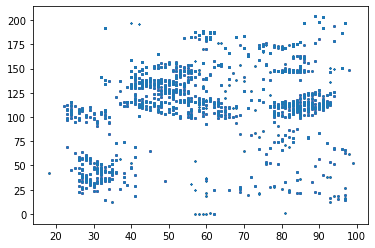

In [36]:
tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
tprogs_elev = np.copy(tprogs_arr)
plt.scatter(np.where(tprogs_arr<0)[1],np.where(tprogs_arr<0)[2],0.2)
# # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
# t = 0
# for k in np.arange(-80,80,0.5):
#     tprogs_elev[t,dem_data<k]= np.NaN
#     t+=1
# masked_tprogs = ma.masked_invalid(tprogs_elev)

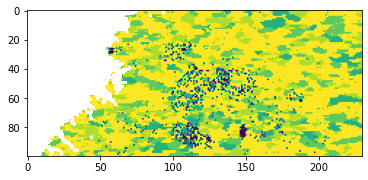

In [46]:
plt.imshow(tprogs_cut_elev(tprogs_line)[180])

In [29]:
# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')


In [28]:
def tprogs_cut_elev(tprogs_line):
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
    tprogs_elev = np.copy(tprogs_arr)
    # the bottom layer of the tprogs model is at -50 m amsl and the top layer is 50 m amsl
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev)
    return(masked_tprogs)

In [35]:
import numpy.ma as ma
def tprogs_cut_saturated(tprogs,kriged):
    tprogs_unsat = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells below the average fall water table depth as np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_unsat[t,kriged>k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_unsat)
    return(masked_tprogs)

In [36]:
def int_to_param(tprogs):
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    tprogs_K = np.copy(tprogs)
    tprogs_Sy = np.copy(tprogs)
    tprogs_Ss = np.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    params = np.asarray([[4e-3,1.5e-3,2.5e-4,6.5e-6],
                         [0.25,0.2,0.15,0.1],
                         [2.0e-5,8e-5,2e-4,5e-4]])
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params[0,n-1]
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params[1,n-1]
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params[2,n-1]
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)


In [37]:
# temporary botm array for tprogs
botm = np.array([[np.arange(-80,80,0.5)]*230]*100)


In [38]:
t=0
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs=tprogs_cut_elev(tprogs_line)
K, Sy, Ss= int_to_param(masked_tprogs)


In [42]:
kriged_fall_avg = np.nanmean(kriged_fall,axis=0)
kriged_spring_avg = np.nanmean(kriged_spring,axis=0)
kriged_fall_spring_avg = (kriged_fall_avg+kriged_spring_avg)/2

In [43]:
unsat_tprogs_fall = tprogs_cut_saturated(K,kriged_fall_avg)
unsat_tprogs_spring = tprogs_cut_saturated(K,kriged_spring_avg)
unsat_tprogs_fall_spring = tprogs_cut_saturated(K,kriged_fall_spring_avg)

In [44]:
np.sum(kriged_fall_avg-kriged_spring_avg)

-121120.0635491809

In [49]:
# calculate the average percent error between fall and spring
harm_err = np.mean(np.abs((hmean(unsat_tprogs_fall,axis=0)-hmean(unsat_tprogs_spring,axis=0)))/hmean(unsat_tprogs_fall,axis=0))
# calculate the average percent error between fall and spring
geom_err = np.mean(np.abs((gmean(unsat_tprogs_fall,axis=0)-gmean(unsat_tprogs_spring,axis=0)))/gmean(unsat_tprogs_fall,axis=0))
harm_err,geom_err

(0.3062307951367699, 0.29883792278921034)

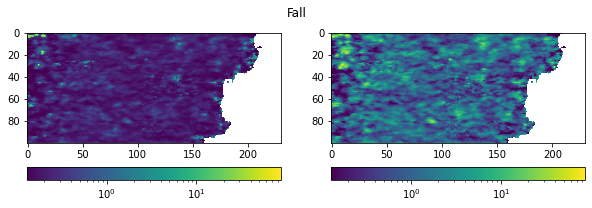

Text(0.5, 0.98, 'Spring')

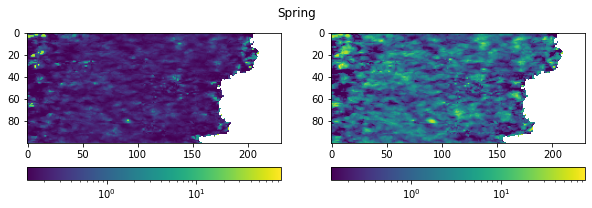

In [248]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
im=ax[0].imshow(hmean(unsat_tprogs_fall,axis=0)*86400,norm=mpl.colors.LogNorm())
plt.colorbar(im,ax=ax[0],orientation = 'horizontal')
im=ax[1].imshow(gmean(unsat_tprogs_fall,axis=0)*86400,norm=mpl.colors.LogNorm())
plt.colorbar(im,ax=ax[1],orientation = 'horizontal')
fig.suptitle('Fall')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(10,3))
im=ax[0].imshow(hmean(unsat_tprogs_spring,axis=0)*86400,norm=mpl.colors.LogNorm())
plt.colorbar(im,ax=ax[0],orientation = 'horizontal')
im=ax[1].imshow(gmean(unsat_tprogs_spring,axis=0)*86400,norm=mpl.colors.LogNorm())
plt.colorbar(im,ax=ax[1],orientation = 'horizontal')
fig.suptitle('Spring')


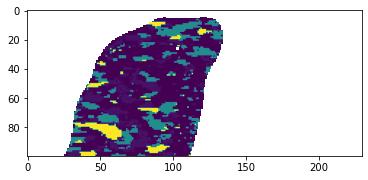

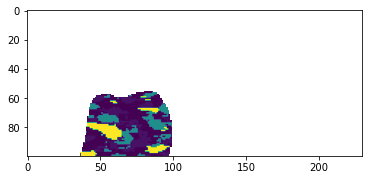

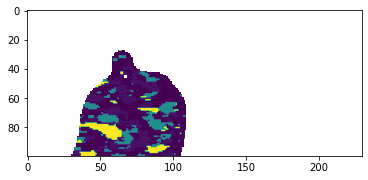

In [245]:
plt.imshow(unsat_tprogs_fall.data[100,:,:])
plt.show()
plt.imshow(unsat_tprogs_spring.data[100,:,:])
plt.show()
plt.imshow(unsat_tprogs_fall_spring.data[100,:,:])

In [212]:
np.nansum(unsat_tprogs_fall.data-unsat_tprogs_spring.data)

0.0

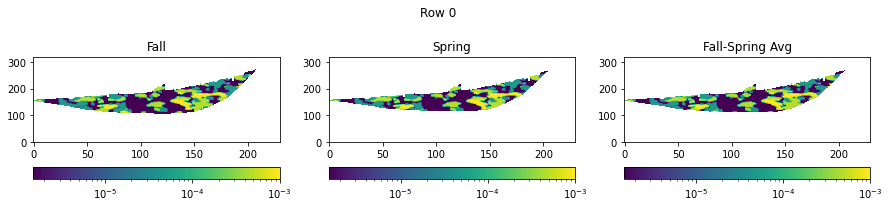

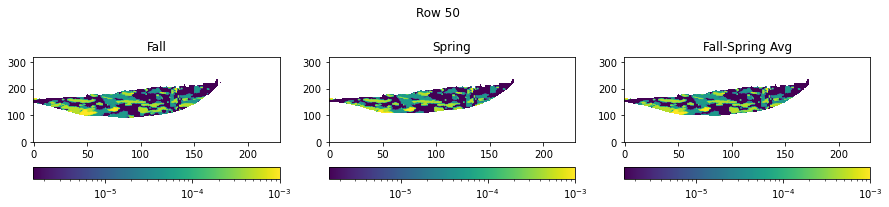

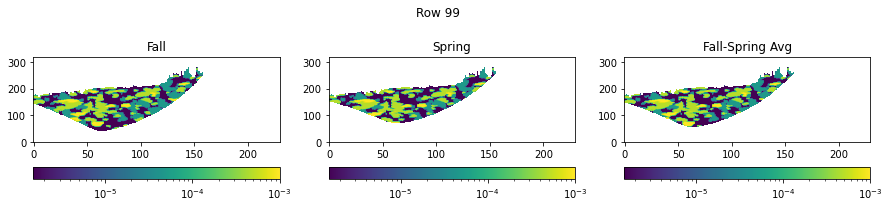

In [261]:
def side_by_side_XS(fall_arr,spring_arr, fall_spring_arr, row,  aspect):
    fig,ax = plt.subplots(1,3,figsize=(15,3))
    im=ax[0].imshow(fall_arr[:,row,:], norm=mpl.colors.LogNorm(),aspect = aspect, origin='lower')
    plt.colorbar(im,ax=ax[0],orientation = 'horizontal')
    ax[0].set_title('Fall')
    im=ax[1].imshow(spring_arr[:,row,:], norm=mpl.colors.LogNorm(),aspect = aspect, origin='lower')
    plt.colorbar(im,ax=ax[1],orientation = 'horizontal')
    ax[1].set_title('Spring')
    im=ax[2].imshow(fall_spring_arr[:,row,:], norm=mpl.colors.LogNorm(),aspect = aspect, origin='lower')
    plt.colorbar(im,ax=ax[2],orientation = 'horizontal')
    ax[2].set_title('Fall-Spring Avg')
    fig.suptitle('Row '+ str(row))
    plt.show()
    
temp = unsat_tprogs_fall
temp2 = unsat_tprogs_spring
temp3 = unsat_tprogs_fall_spring
side_by_side_XS(temp, temp2,temp3, row=0, aspect=1/4)
side_by_side_XS(temp, temp2, temp3, row=50, aspect=1/4)
side_by_side_XS(temp, temp2, temp3, row=99, aspect=1/4)


For the UZF package these cross sections will make up the upscaled vertical hydraulic conductivity. If there are cells without any tprogs cells then it will assume the background hydraulic conductivity to avoid sampling a random cell that could be very high and cause falsely large recharge rates.

In [38]:
n=0
uzf_dir = gwfm_dir+'/UZF_data'
geom_nam = uzf_dir+'/upscaled_tprogs_for_unsaturated_zone/tprogs_geom_k_m_d'+str(n).zfill(3)+'.tsv'
harm_nam = uzf_dir+'/upscaled_tprogs_for_unsaturated_zone/tprogs_harm_k_m_d'+str(n).zfill(3)+'.tsv'

np.savetxt(geom_nam, gmeanupscale*86400, delimiter = '\t')

In [29]:
hmeanupscale.mean()*86400, gmeanupscale.mean()*86400

(0.24210815195404878, 1.4514857104239183)

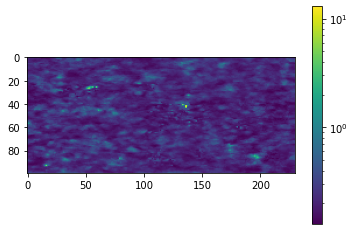

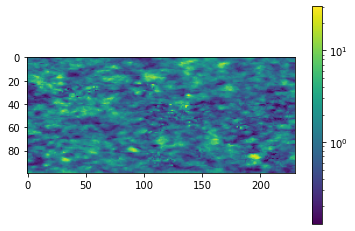

In [52]:
plt.imshow(hmeanupscale*86400,norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
plt.imshow(gmeanupscale*86400,norm=mpl.colors.LogNorm())
plt.colorbar()

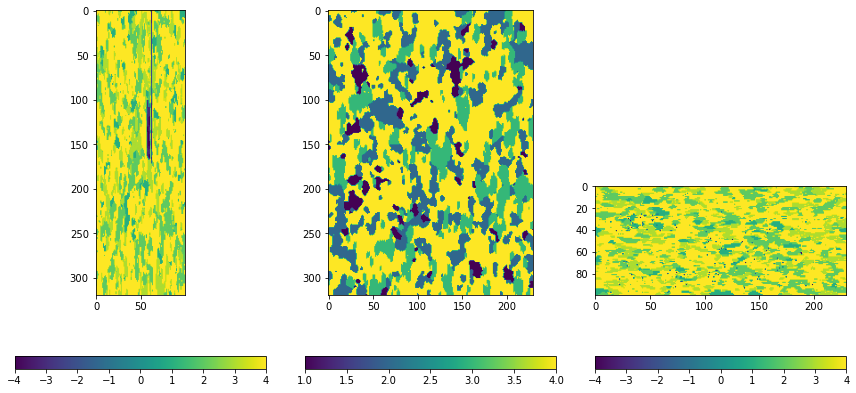

In [65]:
# # col, row, layer 230, 100, 320
# # tprogs_arr = np.reshape(tprogs_line, (230, 100,320))
# tprogs_arr = np.reshape(tprogs_line, (320, 100, 230 ))

# fig, ax = plt.subplots(1,3, figsize=(12,6))
# #first layer
# im = ax[0].imshow(tprogs_arr[:,:,0])
# fig.colorbar(im, ax=ax[0], orientation = 'horizontal')
# # first row
# im = ax[1].imshow(tprogs_arr[:,0,:])
# fig.colorbar(im, ax=ax[1], orientation = 'horizontal')
# # first column
# im = ax[2].imshow(tprogs_arr[0,:,:])
# fig.colorbar(im, ax=ax[2], orientation = 'horizontal')
# fig.tight_layout()

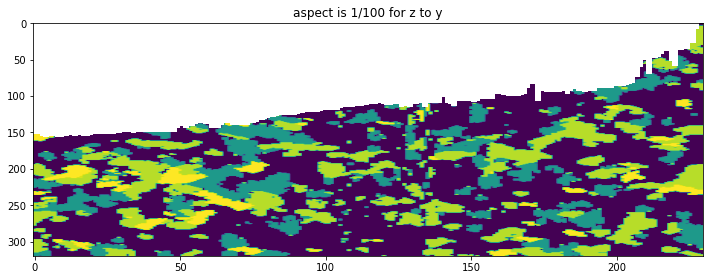

In [60]:
fig, ax = plt.subplots(figsize=(12,12))

# im=ax.imshow(np.flipud(np.transpose(tprogs[:,59,:])),norm=mpl.colors.LogNorm(), aspect=1/10)
plt.imshow(np.flipud(tprogs[:,50,:]),norm=mpl.colors.LogNorm(),aspect=1/4)
# plt.imshow(tprogs[:,50,:],norm=mpl.colors.LogNorm())
plt.title('aspect is 1/100 for z to y')
# fig.colorbar(im, ax=ax, shrink = 0.1)
plt.show()
# plt.imshow(tprogs[0,:,:],norm=mpl.colors.LogNorm())
# plt.colorbar()